In [1]:
import numpy as np
import scipy.io as sio
from pathlib import Path

# ==== CONFIGURACIÓN ====
roi_dir = Path('/home/diego/Escritorio/AAL3/ROISignals_AAL3_NiftiPreprocessedAllBatchesNorm')
mat_files = sorted(roi_dir.glob('ROISignals_*.mat'))

roi_counts = []
tp_counts  = []

for mat_path in mat_files:
    data = sio.loadmat(str(mat_path))
    if 'signals' not in data:
        raise KeyError(f"{mat_path.name} no contiene la variable 'signals'")
    sigs = np.asarray(data['signals'], dtype=float)

    # Suponemos: dim 0 = timepoints, dim 1 = ROIs
    tp, rois = sigs.shape

    tp_counts.append(tp)
    roi_counts.append(rois)

print("Valores únicos en roi_counts:", sorted(set(roi_counts)))
# Debería devolver: [170]



Valores únicos en roi_counts: [170]


In [2]:
EXPECTED_ROIS = 170
mismatches = []

for mat_path in mat_files:
    data = sio.loadmat(str(mat_path))
    sigs = np.asarray(data['signals'], dtype=float)
    d0, d1 = sigs.shape
    if d1 != EXPECTED_ROIS:
        mismatches.append((mat_path.name, sigs.shape))

if mismatches:
    print("Archivos sin 170 columnas en 'signals':")
    for name, shape in mismatches:
        print(f"  • {name:30s} shape={shape}")
else:
    print("✔️ Todos los archivos tienen 170 ROIs (dimensión 1).")




✔️ Todos los archivos tienen 170 ROIs (dimensión 1).


In [3]:
from scipy.io import whosmat

info = whosmat('/home/diego/Escritorio/AAL3/ROISignals_AAL3_NiftiPreprocessedAllBatchesNorm/ROISignals_002_S_0295.mat')
print(info)


[('signals', (140, 170), 'double')]


Time-points: min=140, max=200, media=177.0, mediana=197.0


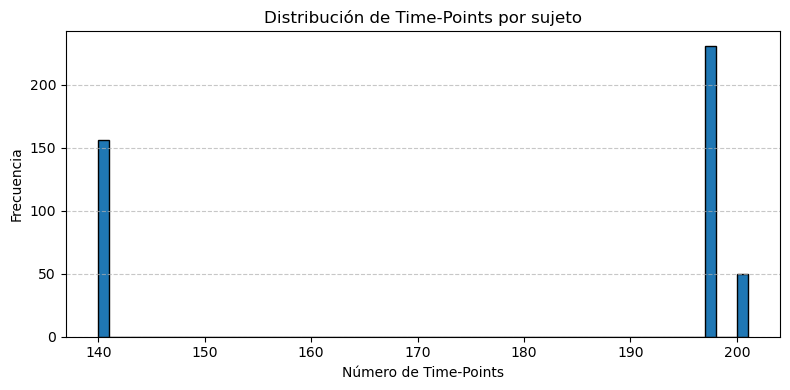

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que tp_counts ya está poblado
# tp_counts = [...]

# Estadísticas básicas
tp_array = np.array(tp_counts)
print(f"Time-points: min={tp_array.min()}, max={tp_array.max()}, media={tp_array.mean():.1f}, mediana={np.median(tp_array)}")

# Histograma
plt.figure(figsize=(8,4))
plt.hist(tp_array, bins=range(tp_array.min(), tp_array.max()+2), edgecolor='black')
plt.title('Distribución de Time-Points por sujeto')
plt.xlabel('Número de Time-Points')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



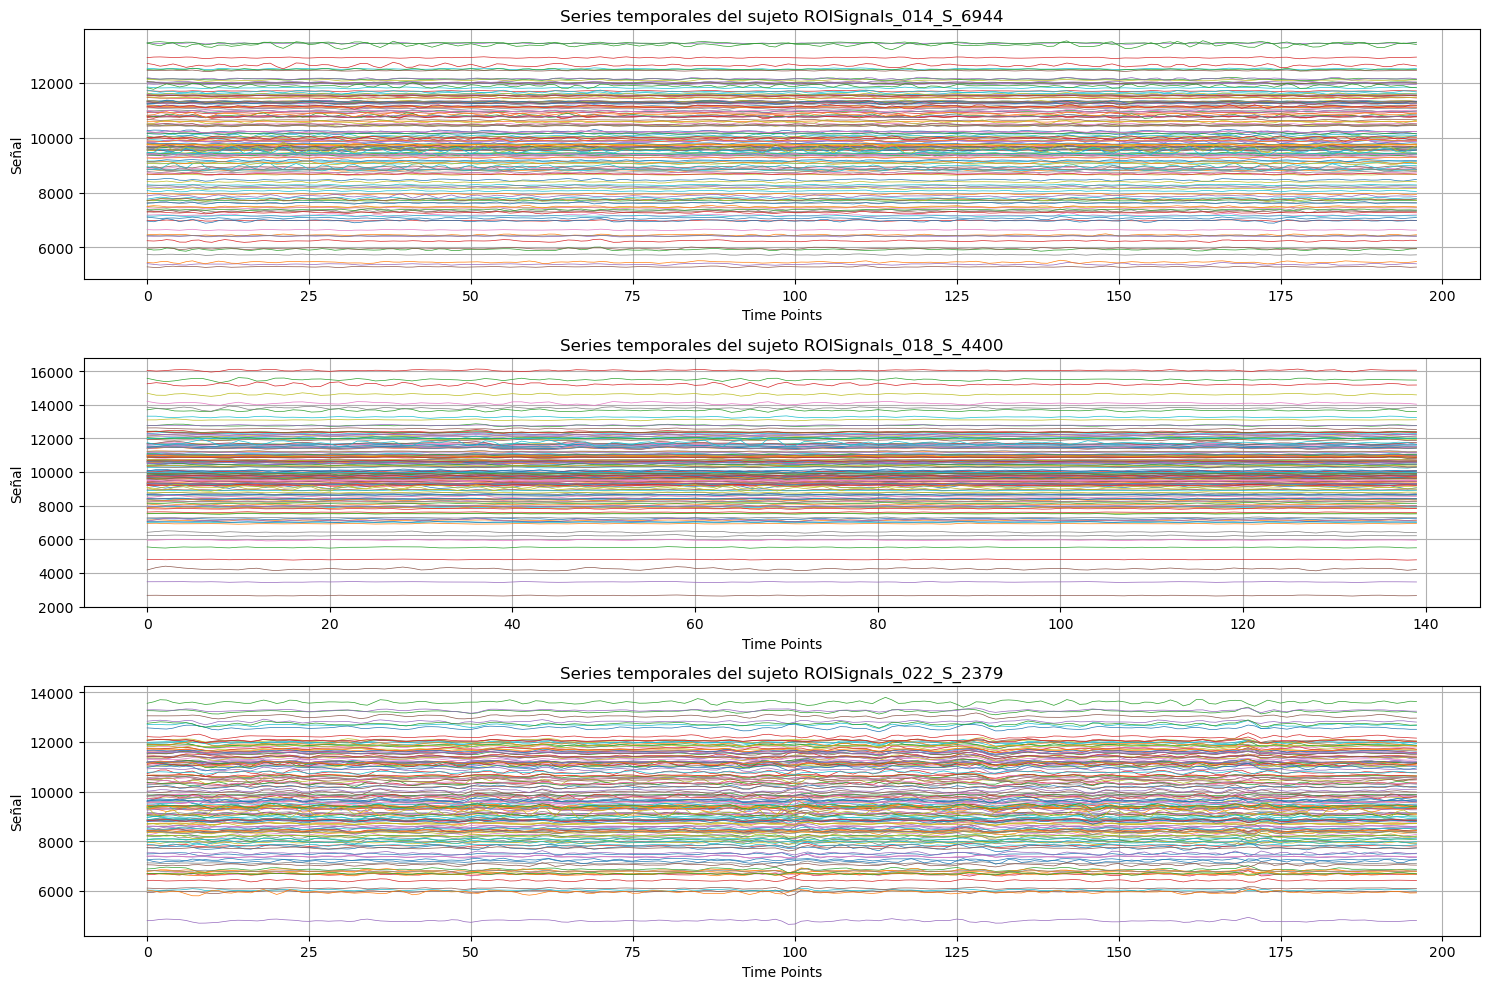

Time-points tras remover nulos: min=140, max=200, media=177.0, mediana=197.0


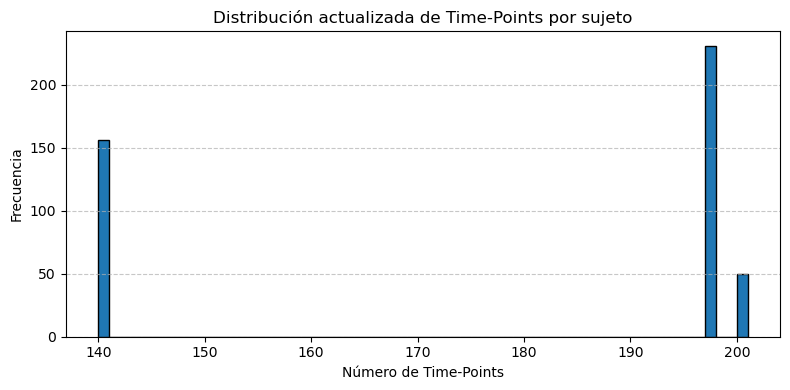

In [5]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from pathlib import Path

# Ruta del directorio
roi_dir = Path('/home/diego/Escritorio/AAL3/ROISignals_AAL3_NiftiPreprocessedAllBatchesNorm')
mat_files = sorted(roi_dir.glob('ROISignals_*.mat'))

# Cargar datos
roi_counts = []
tp_counts = []
signals_data = []
subject_ids = []

for mat_path in mat_files:
    data = sio.loadmat(str(mat_path))
    sigs = np.asarray(data['signals'], dtype=float)
    tp, rois = sigs.shape
    
    if np.all(sigs == 0):
        print(f"{mat_path.name} tiene señales completamente nulas.")
        continue  # Excluir sujetos con señales completamente nulas

    signals_data.append(sigs)
    tp_counts.append(tp)
    roi_counts.append(rois)
    subject_ids.append(mat_path.stem)

# Seleccionar aleatoriamente algunos sujetos para graficar sus series temporales
selected_subjects_idx = np.random.choice(len(signals_data), size=3, replace=False)
selected_subjects = [signals_data[i] for i in selected_subjects_idx]
selected_subject_ids = [subject_ids[i] for i in selected_subjects_idx]

# Graficar las series temporales seleccionadas
plt.figure(figsize=(15, 10))
for i, (subj_data, subj_id) in enumerate(zip(selected_subjects, selected_subject_ids), start=1):
    plt.subplot(3, 1, i)
    plt.plot(subj_data, linewidth=0.5)
    plt.title(f'Series temporales del sujeto {subj_id}')
    plt.xlabel('Time Points')
    plt.ylabel('Señal')
    plt.grid(True)

plt.tight_layout()
plt.show()

# Mostrar estadísticas actualizadas luego de remover sujetos nulos
tp_array = np.array(tp_counts)
print(f"Time-points tras remover nulos: min={tp_array.min()}, max={tp_array.max()}, media={tp_array.mean():.1f}, mediana={np.median(tp_array)}")

# Histograma actualizado de Time Points
plt.figure(figsize=(8, 4))
plt.hist(tp_array, bins=range(tp_array.min(), tp_array.max() + 2), edgecolor='black')
plt.title('Distribución actualizada de Time-Points por sujeto')
plt.xlabel('Número de Time-Points')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

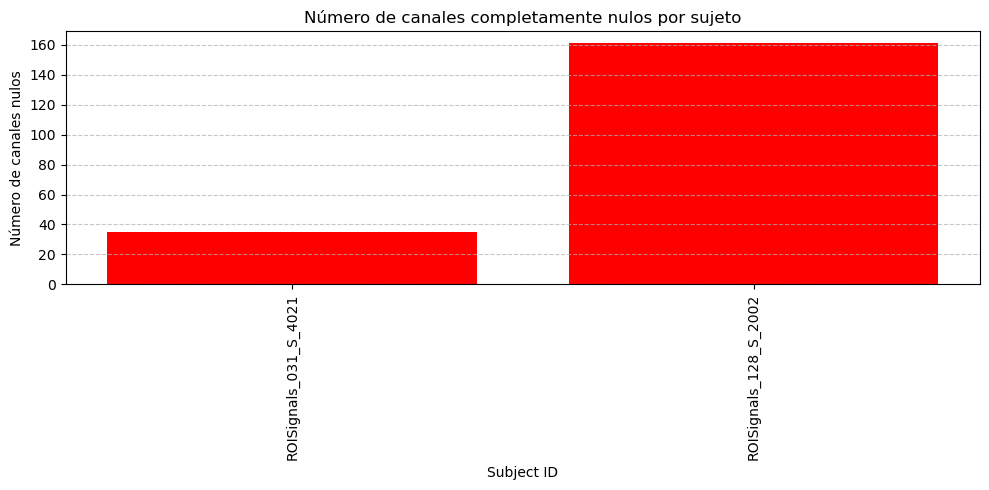

([35, 161], ['ROISignals_031_S_4021', 'ROISignals_128_S_2002'])

In [6]:
import numpy as np
import scipy.io as sio
from pathlib import Path
import matplotlib.pyplot as plt

# Configuración inicial
roi_dir = Path('/home/diego/Escritorio/AAL3/ROISignals_AAL3_NiftiPreprocessedAllBatchesNorm')
mat_files = sorted(roi_dir.glob('ROISignals_*.mat'))

nulos_por_sujeto = []
subject_ids_nulos = []

# Análisis de señales nulas por canal
for mat_path in mat_files:
    data = sio.loadmat(str(mat_path))
    sigs = np.asarray(data['signals'], dtype=float)
    
    # Canales (ROIs) completamente nulos (todos los time points = 0)
    canales_nulos = np.all(sigs == 0, axis=0)
    cantidad_nulos = np.sum(canales_nulos)
    
    if cantidad_nulos > 0:
        nulos_por_sujeto.append(cantidad_nulos)
        subject_ids_nulos.append(mat_path.stem)

# Reporte de sujetos con canales completamente nulos
plt.figure(figsize=(10, 5))
plt.bar(subject_ids_nulos, nulos_por_sujeto, color='red')
plt.title('Número de canales completamente nulos por sujeto')
plt.xlabel('Subject ID')
plt.ylabel('Número de canales nulos')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Mostrar detalles adicionales
nulos_por_sujeto, subject_ids_nulos


       TotalOutliers  PercentOutliers
count     437.000000       437.000000
mean       49.741419         0.163729
std        51.415241         0.157412
min         0.000000         0.000000
25%        19.000000         0.063025
50%        35.000000         0.116453
75%        63.000000         0.200060
max       487.000000         1.454165


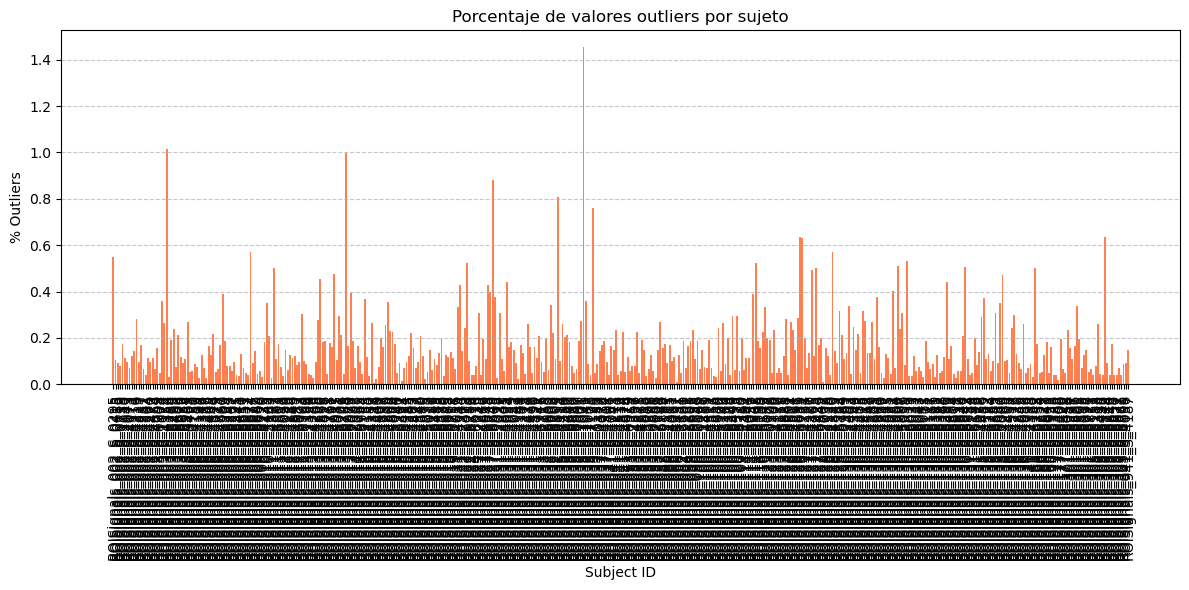

In [7]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import zscore
import pandas as pd

# Directorio de datos
roi_dir = Path('/home/diego/Escritorio/AAL3/ROISignals_AAL3_NiftiPreprocessedAllBatchesNorm')
mat_files = sorted(roi_dir.glob('ROISignals_*.mat'))

# DataFrame para almacenar resultados
outlier_summary = []

for mat_path in mat_files:
    data = sio.loadmat(str(mat_path))
    sigs = np.asarray(data['signals'], dtype=float)

    # Identificar outliers con Z-score absoluto superior a un umbral (típicamente 3 o 3.5)
    z_scores = np.abs(zscore(sigs, axis=0, nan_policy='omit'))
    outliers_mask = z_scores > 3.5
    
    # Estadísticas de outliers
    total_outliers = np.sum(outliers_mask)
    pct_outliers = (total_outliers / sigs.size) * 100

    outlier_summary.append({
        'Subject': mat_path.stem,
        'TotalOutliers': total_outliers,
        'PercentOutliers': pct_outliers
    })

# Convertir a DataFrame
outliers_df = pd.DataFrame(outlier_summary)

# Mostrar resumen estadístico
print(outliers_df.describe())

# Visualización gráfica de los outliers
plt.figure(figsize=(12, 6))
plt.bar(outliers_df['Subject'], outliers_df['PercentOutliers'], color='coral')
plt.title('Porcentaje de valores outliers por sujeto')
plt.xlabel('Subject ID')
plt.ylabel('% Outliers')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

                   Subject  OutliersCount  OutliersPct
202  ROISignals_035_S_7021            487     1.454165
23   ROISignals_003_S_4354            340     1.015228
100  ROISignals_013_S_6768            334     0.997313
163  ROISignals_027_S_6849            299     0.879412
191  ROISignals_032_S_6855            270     0.806211
206  ROISignals_035_S_7120            254     0.758435
426  ROISignals_305_S_6742            213     0.636011
295  ROISignals_126_S_6683            216     0.635294
296  ROISignals_126_S_6721            214     0.629412
309  ROISignals_128_S_2220            194     0.570588


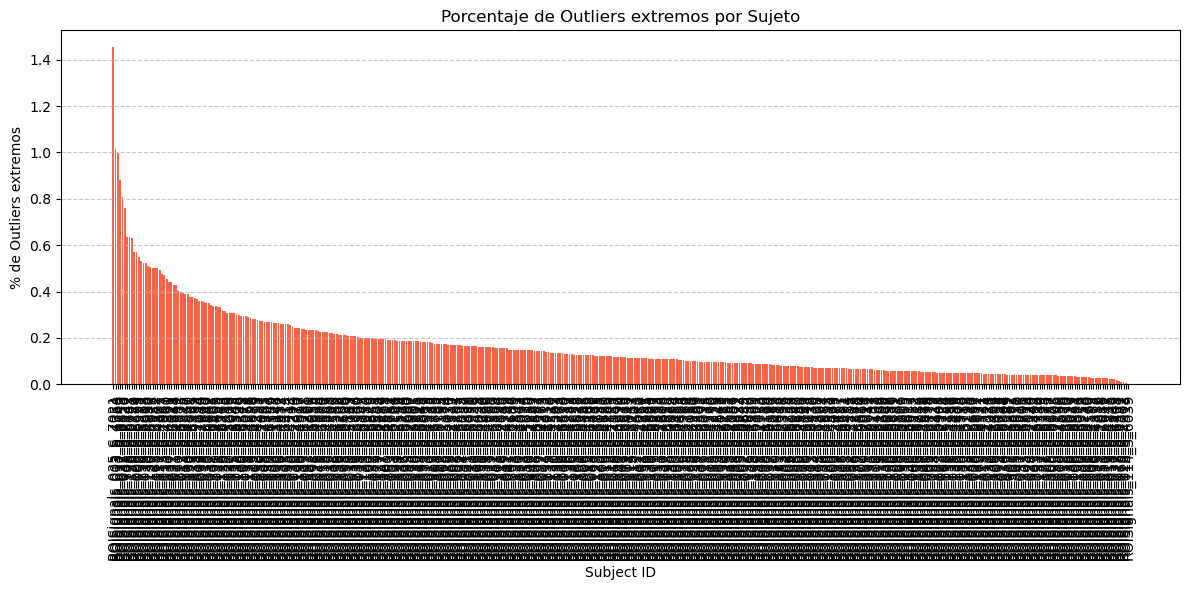

In [8]:
import numpy as np
import scipy.io as sio
from pathlib import Path
from scipy.stats import zscore
import pandas as pd
import matplotlib.pyplot as plt

# Configuración
roi_dir = Path('/home/diego/Escritorio/AAL3/ROISignals_AAL3_NiftiPreprocessedAllBatchesNorm')
mat_files = sorted(roi_dir.glob('ROISignals_*.mat'))

subject_outliers = []

# Análisis de outliers por sujeto
for mat_path in mat_files:
    data = sio.loadmat(str(mat_path))
    sigs = np.asarray(data['signals'], dtype=float)
    
    # Calcular Z-score por ROI (columna)
    z_scores = np.abs(zscore(sigs, axis=0, nan_policy='omit'))

    # Contar cantidad de outliers extremos (Z-score > 3.5)
    outliers_count = np.sum(z_scores > 3.5)

    # Proporción de outliers
    outliers_pct = 100 * outliers_count / sigs.size

    subject_outliers.append({
        'Subject': mat_path.stem,
        'OutliersCount': outliers_count,
        'OutliersPct': outliers_pct
    })

# Crear DataFrame y ordenar
outliers_df = pd.DataFrame(subject_outliers)
outliers_df = outliers_df.sort_values(by='OutliersPct', ascending=False)

# Mostrar top sujetos potencialmente problemáticos
print(outliers_df.head(10))

# Gráfica para visualizar sujetos con más outliers
plt.figure(figsize=(12, 6))
plt.bar(outliers_df['Subject'], outliers_df['OutliersPct'], color='tomato')
plt.xlabel('Subject ID')
plt.ylabel('% de Outliers extremos')
plt.title('Porcentaje de Outliers extremos por Sujeto')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Top 10 sujetos con mayor porcentaje de outliers:
                 Subject  OutliersCount  OutliersPct
0  ROISignals_035_S_7021            487     1.454165
1  ROISignals_003_S_4354            340     1.015228
2  ROISignals_013_S_6768            334     0.997313
3  ROISignals_027_S_6849            299     0.879412
4  ROISignals_032_S_6855            270     0.806211
5  ROISignals_035_S_7120            254     0.758435
6  ROISignals_305_S_6742            213     0.636011
7  ROISignals_126_S_6683            216     0.635294
8  ROISignals_126_S_6721            214     0.629412
9  ROISignals_128_S_2220            194     0.570588

Umbral IQR + 1.5*IQR = 0.406% de outliers
Sujeto(s) para descartar:
                  Subject  OutliersCount  OutliersPct
0   ROISignals_035_S_7021            487     1.454165
1   ROISignals_003_S_4354            340     1.015228
2   ROISignals_013_S_6768            334     0.997313
3   ROISignals_027_S_6849            299     0.879412
4   ROISignals_032_S_6855    

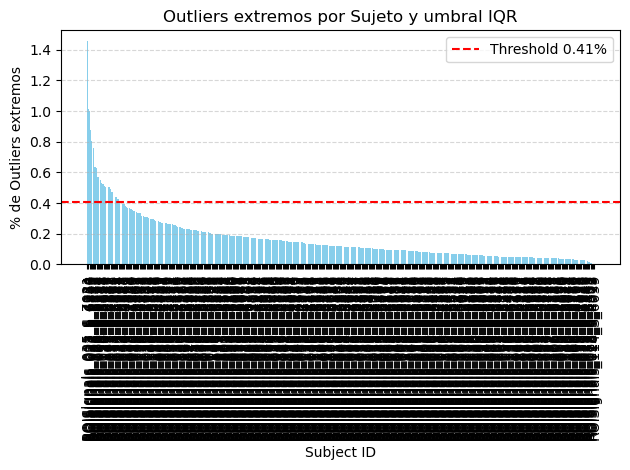

In [9]:
import numpy as np
import scipy.io as sio
from pathlib import Path
from scipy.stats import zscore
import pandas as pd
import matplotlib.pyplot as plt

# Directorio de datos
roi_dir = Path('/home/diego/Escritorio/AAL3/ROISignals_AAL3_NiftiPreprocessedAllBatchesNorm')
mat_files = sorted(roi_dir.glob('ROISignals_*.mat'))

# DataFrame para almacenar resumen de outliers por sujeto
subject_outliers = []

for mat_path in mat_files:
    data = sio.loadmat(str(mat_path))
    sigs = np.asarray(data['signals'], dtype=float)

    # Calcular Z-score absoluto por ROI (axis=0)
    z_scores = np.abs(zscore(sigs, axis=0, nan_policy='omit'))
    
    # Contar outliers extremos (Z > 3.5)
    outliers_count = np.sum(z_scores > 3.5)
    outliers_pct = (outliers_count / sigs.size) * 100

    subject_outliers.append({
        'Subject': mat_path.stem,
        'OutliersCount': outliers_count,
        'OutliersPct': outliers_pct
    })

# Convertir a DataFrame y ordenar por porcentaje de outliers descendente
outliers_df = pd.DataFrame(subject_outliers)
outliers_df = outliers_df.sort_values(by='OutliersPct', ascending=False).reset_index(drop=True)

# Mostrar top 10 sujetos con más outliers
print("Top 10 sujetos con mayor porcentaje de outliers:")
print(outliers_df.head(10))

# Identificar sujetos outliers según método IQR
q1 = outliers_df['OutliersPct'].quantile(0.25)
q3 = outliers_df['OutliersPct'].quantile(0.75)
iqr = q3 - q1
threshold = q3 + 1.5 * iqr

# Sujetos para descartar
to_discard = outliers_df[outliers_df['OutliersPct'] > threshold]
print(f"\nUmbral IQR + 1.5*IQR = {threshold:.3f}% de outliers")
print("Sujeto(s) para descartar:")
print(to_discard)

# Visualización: porcentaje de outliers con umbral marcado\plt.figure(figsize=(12, 6))
plt.bar(outliers_df['Subject'], outliers_df['OutliersPct'], color='skyblue')
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold {threshold:.2f}%')
plt.xlabel('Subject ID')
plt.ylabel('% de Outliers extremos')
plt.title('Outliers extremos por Sujeto y umbral IQR')
plt.xticks(rotation=90)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
